In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
import seaborn as sns
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import random

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x2 = f(R1)
    t_x2 = t(R1)
    condition = R2*t_x2 <=f_x2
    [plt.plot(R1[i],R2[i]*t_x2[i],'ob') if condition[i] else plt.plot(R1[i],R2[i]*t_x2[i],'o') \
         for i in range(len(R1))]
                
    plt.show()
    
    return x

def Acep_rechazo3(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1)
    t_x = t(R1)
    condition = R2*t_x <=f_x
    x = [R1[i] for i in range(len(R1)) if condition[i]]
                
    return x

def kde_statsmodels_m2(x, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return lambda x_i: kde.pdf(x_i)




kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print( "Package Versions:")
import sklearn; print( "  scikit-learn:", sklearn.__version__)
import scipy; print ("  scipy:", scipy.__version__)
import statsmodels; print( "  statsmodels:", statsmodels.__version__)

Package Versions:
  scikit-learn: 1.2.2
  scipy: 1.9.1
  statsmodels: 0.13.2


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Simulación de información histórica

In [3]:
import pandas as pd
tc_dolar = pd.read_excel(
    "Tipo de cambio.xlsx",
    sheet_name="DOLARPESO",
    index_col=[0],
    usecols=[0, 1]
)
x= tc_dolar.values
x= x.ravel()
x.shape

# El grid que usaremos para graficar
x_grid = np.linspace(10, 30, 1000)


### Histograma

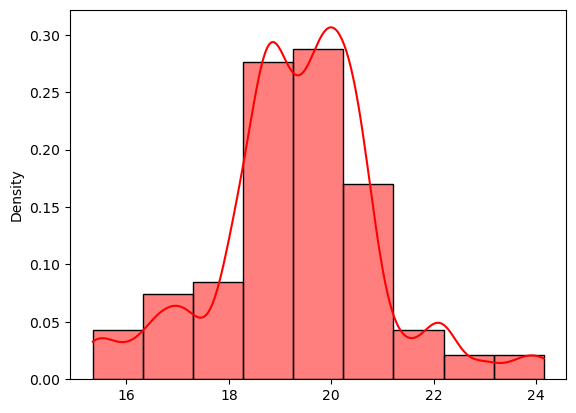

In [4]:
sns.histplot(data=x, stat='density', kde=True, kde_kws={'bw_method': .2}, color='r', bins=9);

<AxesSubplot:ylabel='Density'>

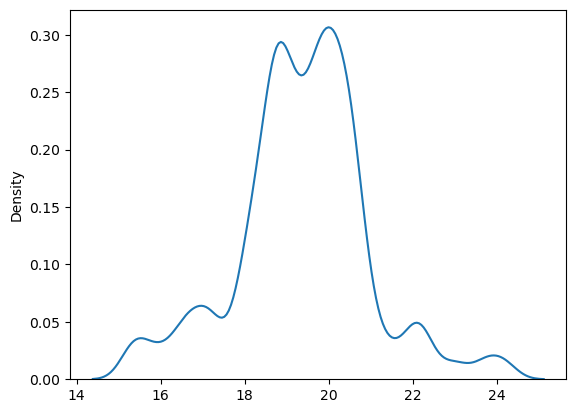

In [5]:
sns.kdeplot(data=x, bw_method=0.2)

### Selección de ancho de banda

La selección del ancho debanda es muy importante del KDE. Para los mismos datos, diferentes anchos de banda pueden producir diferentes resultados. 

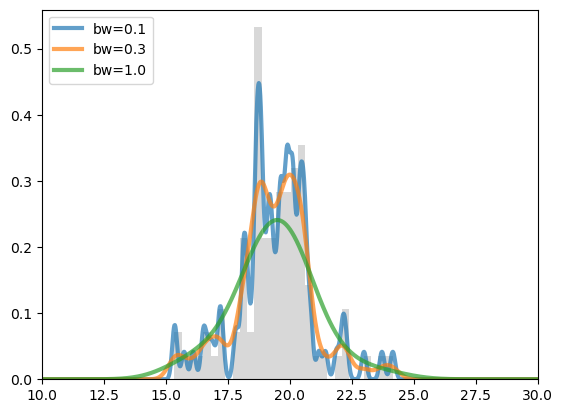

In [6]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(10, 30)
ax.legend(loc='upper left')

### Validación cruzada de ancho de banda en Scikit-Learn

In [7]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

{'bandwidth': 1.0}


In [8]:
f = lambda x: grid.score_samples(x[:, None])
f(np.array([1]))

array([-107.84959624])

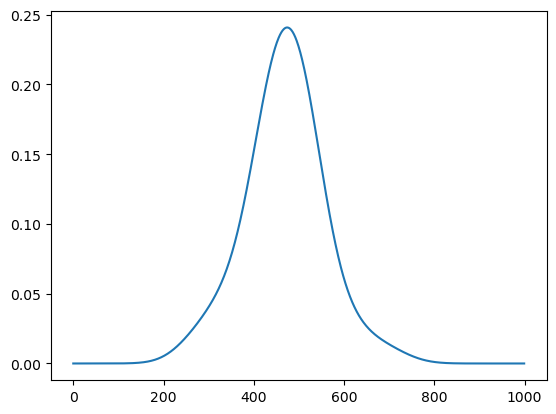

In [9]:
plt.plot(np.exp(grid.score_samples(x_grid[:, None])))

Text(0.5, 1.0, 'KDE using scikit-learn')

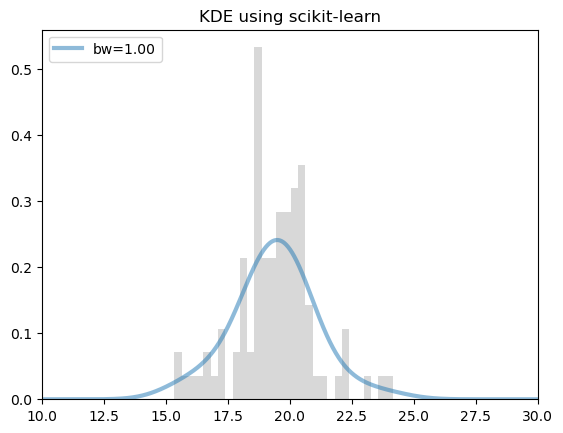

In [10]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(10, 30);
ax.set_title('KDE using scikit-learn')

### Validación cruzada de ancho de banda in Stats-models

#### Función de densidad de probabilidad

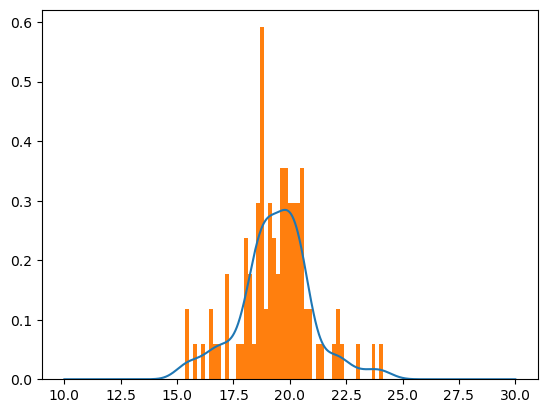

In [11]:
pdf = kde_statsmodels_m2(x)
plt.plot(x_grid, pdf(x_grid));
plt.hist(x, bins=50, density=True);

#### Función de distribución acumulada CDF

In [12]:
cdf= np.cumsum(pdf(x_grid))

Text(0.5, 1.0, 'Función de distribución acumulada CDF')

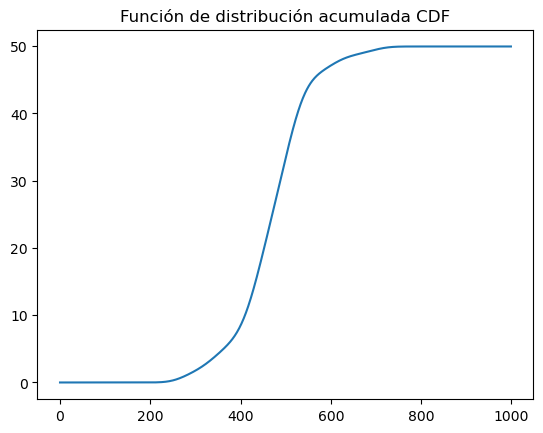

In [13]:
plt.plot(cdf)
plt.title("Función de distribución acumulada CDF")

### Método de Acpetación-Rechazo

In [14]:
from scipy import optimize
f = pdf
a=f(optimize.fmin(lambda x:-f(x), 0, disp=False))
t =lambda x: a * np.ones(len(x))
x = np.arange(10, 30, 0.01)
print('El máximo de f es:',a)

El máximo de f es: 0.28457366751666824


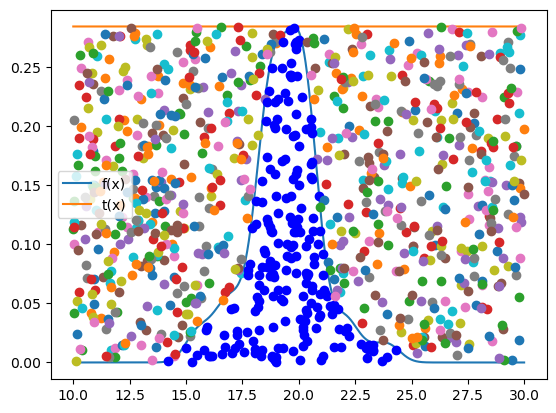

array([10.  , 10.01, 10.02, ..., 29.97, 29.98, 29.99])

In [15]:
N = 1000
R2 = np.random.rand(N)
R1 = [random.uniform(10, 30) for i in range(N)]
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()
Acep_rechazo(R2, R1, f, t)

In [16]:
Acep_rechazo3(R2, R1, f, t)

[20.889323662645015,
 21.47420006909598,
 21.363518451299264,
 20.306700743835215,
 19.990352665201783,
 20.046849140438937,
 19.926960477624725,
 20.55398775931401,
 18.72204530842214,
 18.628129536608437,
 19.90848342896227,
 14.981408316746377,
 19.76084308969675,
 19.21834708881735,
 20.599927406649364,
 19.864969543759443,
 18.37457381837384,
 18.576862226334963,
 20.215049247948976,
 18.81609055508052,
 18.350335419040626,
 18.907707925783914,
 19.79811318752593,
 24.3202843843214,
 15.927362626572187,
 18.60342029601309,
 19.000353475219786,
 19.64303366899806,
 19.76746769822273,
 18.06708976928964,
 23.930052600265302,
 21.26955856153727,
 18.743364403792334,
 19.71492579293908,
 18.251383620855673,
 19.069530602520715,
 19.87659664111718,
 17.924997781954268,
 18.996604003757355,
 19.75234443303522,
 19.591699110023377,
 20.751239855224902,
 20.165294471231498,
 19.056247479750628,
 18.85869109082779,
 18.935933324392728,
 18.33378154298874,
 18.546519972397952,
 19.438243686

## Simulación del diferencial de inflación

In [17]:
dif_inf = pd.read_excel(
    "Inflacion Mexico.xlsx",
    sheet_name="Hoja3",
    index_col=[0],
    usecols=[0, 1]
)
#Datos
dif_inf

,Diferencial
Fecha,
2023 Mar,0.03
2023 Feb,0.04
2023 Ene,0.12
2022 Sep,0.42
2022 Oct,0.17
...,...
2015 Jun,0.23
2015 Jul,0.15
2015 Dic,0.71


In [18]:
y= dif_inf.values
y= y.ravel()
y.shape
y_grid = np.linspace(0, 1.5, 1000)

### Histograma

<AxesSubplot:>

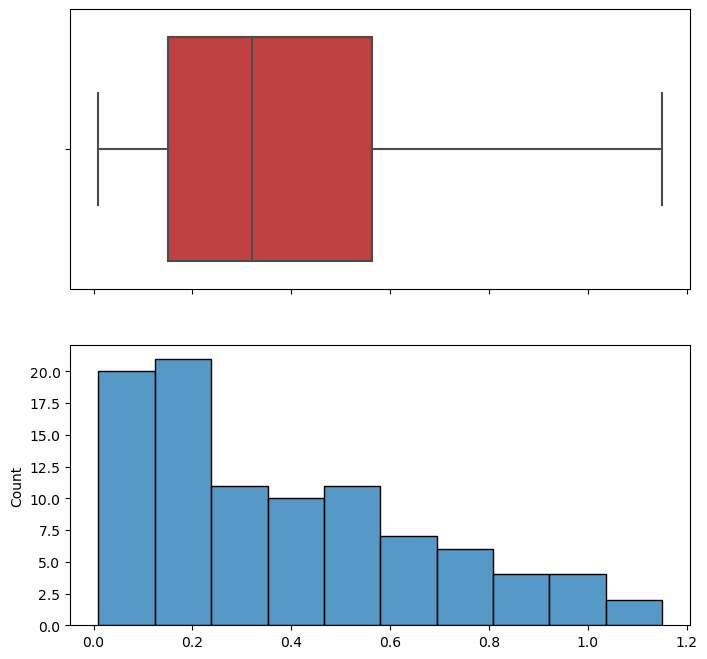

In [34]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex= True,figsize=(8,8))
sns.histplot(y, ax=ax2, bins=10)
sns.boxplot(x=y, ax=ax1, saturation=.5, color='r')

<AxesSubplot:ylabel='Density'>

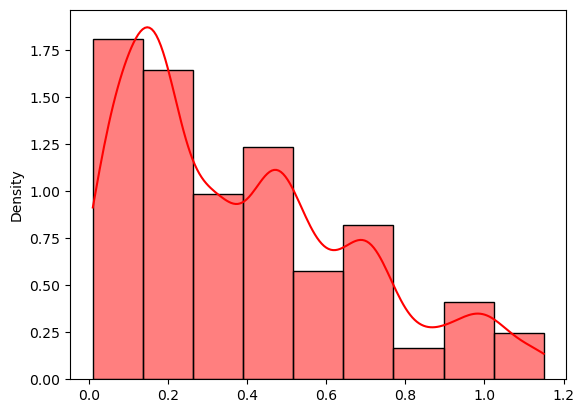

In [19]:
sns.histplot(data=y, stat='density', kde=True, kde_kws={'bw_method': .2}, color='r', bins=9)

<AxesSubplot:ylabel='Density'>

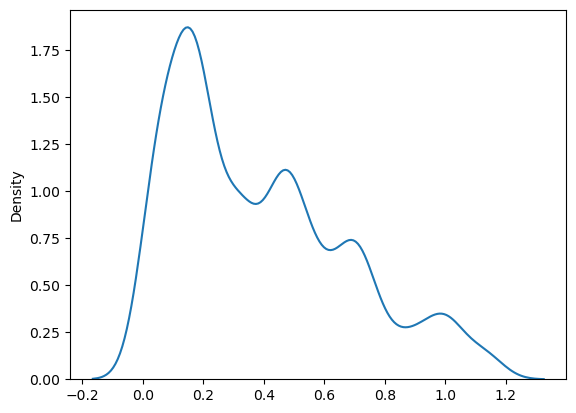

In [20]:
sns.kdeplot(data=y, bw_method=0.2)

### Selección de ancho de banda

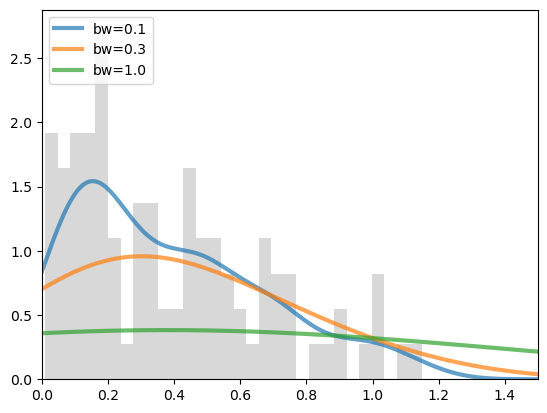

In [21]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(y_grid, kde_sklearn(y, y_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(y, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(0, 1.5)
ax.legend(loc='upper left')

### Validación cruzada de ancho de banda en Scikit-Learn

In [22]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(y[:, None])
print(grid.best_params_)

{'bandwidth': 0.1}


In [23]:
f = lambda y: grid.score_samples(y[:, None])
f(np.array([1]))

array([-1.23864039])

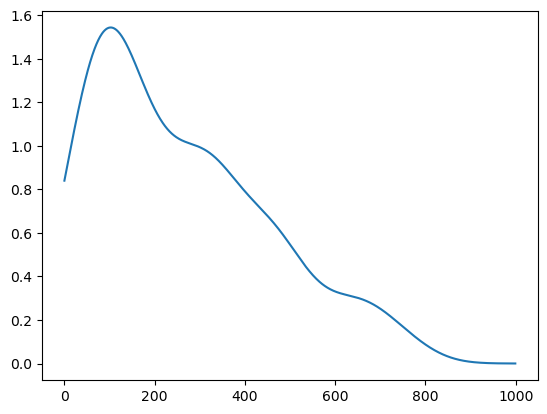

In [24]:
plt.plot(np.exp(grid.score_samples(y_grid[:, None])))

Text(0.5, 1.0, 'KDE using scikit-learn')

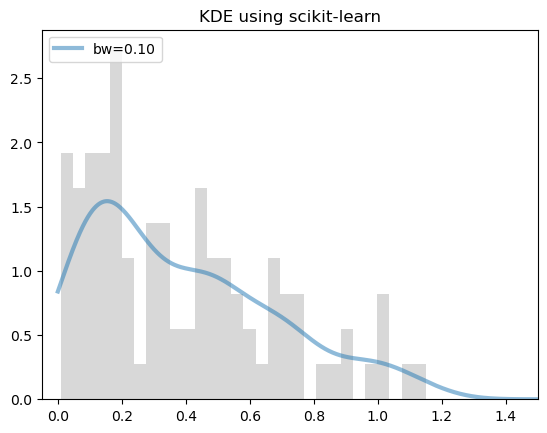

In [25]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(y_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(y_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(y, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-.05, 1.5, 30);
ax.set_title('KDE using scikit-learn')

### Validación cruzada de ancho de banda in Stats-models

#### Función de densidad de probabilidad

C:\Users\av1la\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


(array([2.28435673, 1.37061404, 1.82748538, 1.37061404, 2.28435673,
        0.91374269, 2.28435673, 4.56871345, 0.91374269, 0.91374269,
        0.45687135, 0.91374269, 0.        , 2.74122807, 0.91374269,
        0.45687135, 0.45687135, 0.91374269, 0.45687135, 2.28435673,
        1.37061404, 1.82748538, 0.        , 0.45687135, 1.37061404,
        0.45687135, 0.45687135, 0.45687135, 0.45687135, 1.37061404,
        0.91374269, 0.45687135, 1.37061404, 0.        , 0.        ,
        0.45687135, 0.45687135, 0.        , 0.        , 0.91374269,
        0.        , 0.        , 0.45687135, 0.91374269, 0.45687135,
        0.        , 0.        , 0.45687135, 0.        , 0.45687135]),
 array([0.01  , 0.0328, 0.0556, 0.0784, 0.1012, 0.124 , 0.1468, 0.1696,
        0.1924, 0.2152, 0.238 , 0.2608, 0.2836, 0.3064, 0.3292, 0.352 ,
        0.3748, 0.3976, 0.4204, 0.4432, 0.466 , 0.4888, 0.5116, 0.5344,
        0.5572, 0.58  , 0.6028, 0.6256, 0.6484, 0.6712, 0.694 , 0.7168,
        0.7396, 0.7624, 0.7852

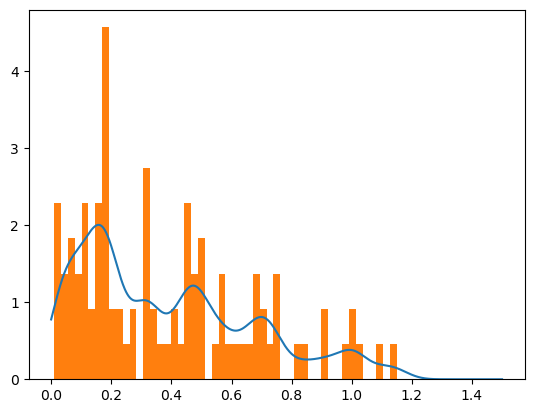

In [26]:
kde_statsmodels_m2(y)
pdf_y = kde_statsmodels_m2(y)
plt.plot(y_grid, pdf_y(y_grid))
plt.hist(y, bins=50, density=True)

#### Función de distribución acumulada CDF

In [27]:
cdf_y= np.cumsum(pdf_y(y_grid))

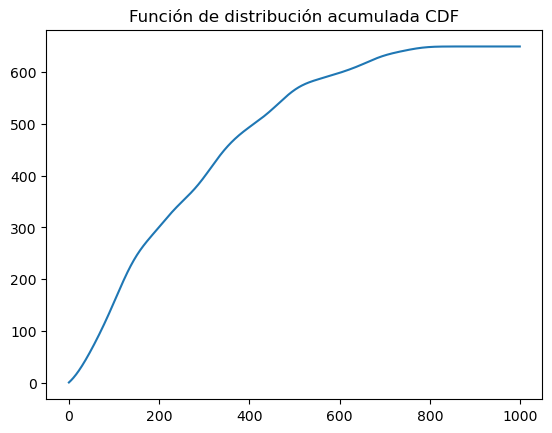

In [28]:
plt.plot(cdf_y);
plt.title("Función de distribución acumulada CDF");

## Método Aceptación Rechazo

In [29]:
from scipy import optimize
f = pdf_y
a=f(optimize.fmin(lambda x:-f(x), 0, disp=False))
t =lambda x: a * np.ones(len(x))
x = np.arange(-.5, 1.5, 0.01)
print('El máximo de f es:',a)

El máximo de f es: 2.0043417330670823


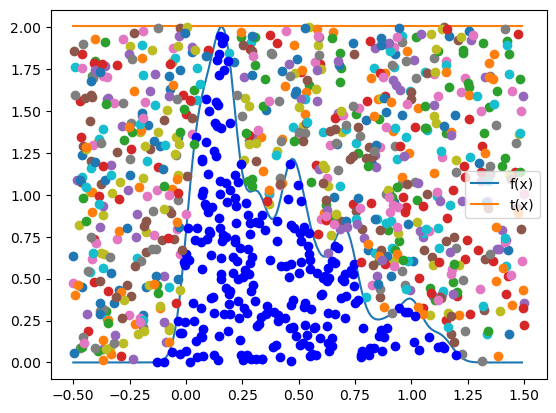

array([-5.0000000e-01, -4.9000000e-01, -4.8000000e-01, -4.7000000e-01,
       -4.6000000e-01, -4.5000000e-01, -4.4000000e-01, -4.3000000e-01,
       -4.2000000e-01, -4.1000000e-01, -4.0000000e-01, -3.9000000e-01,
       -3.8000000e-01, -3.7000000e-01, -3.6000000e-01, -3.5000000e-01,
       -3.4000000e-01, -3.3000000e-01, -3.2000000e-01, -3.1000000e-01,
       -3.0000000e-01, -2.9000000e-01, -2.8000000e-01, -2.7000000e-01,
       -2.6000000e-01, -2.5000000e-01, -2.4000000e-01, -2.3000000e-01,
       -2.2000000e-01, -2.1000000e-01, -2.0000000e-01, -1.9000000e-01,
       -1.8000000e-01, -1.7000000e-01, -1.6000000e-01, -1.5000000e-01,
       -1.4000000e-01, -1.3000000e-01, -1.2000000e-01, -1.1000000e-01,
       -1.0000000e-01, -9.0000000e-02, -8.0000000e-02, -7.0000000e-02,
       -6.0000000e-02, -5.0000000e-02, -4.0000000e-02, -3.0000000e-02,
       -2.0000000e-02, -1.0000000e-02,  4.4408921e-16,  1.0000000e-02,
        2.0000000e-02,  3.0000000e-02,  4.0000000e-02,  5.0000000e-02,
      

In [32]:
N = 1000
R2 = np.random.rand(N)
R1 = [random.uniform(-.5, 1.5) for i in range(N)]
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()
Acep_rechazo(R2, R1, f, t)

In [33]:
Acep_rechazo3(R2, R1, f, t)

[0.08780808654936578,
 0.09565963182796433,
 0.4645974627017564,
 0.324128983194927,
 0.9437859758588147,
 0.08496813593909591,
 0.5076586330017872,
 0.08955412008400976,
 0.31198623807430836,
 0.7853706571050125,
 0.06909617193031403,
 0.4049380776578959,
 1.1164680983086908,
 0.22619267168417845,
 0.1629674063245241,
 0.6900003306877709,
 0.3042250255098684,
 0.6076514118889604,
 0.15258113486017288,
 0.4756830307321329,
 0.6310017662606044,
 0.5799412877259591,
 0.275105186252,
 0.10825950261668482,
 0.7404102823311658,
 0.46636753197882985,
 -0.02744921308769599,
 0.8918609549539298,
 0.03455238408685801,
 0.4970213633095466,
 0.8781005455696071,
 -0.01645660435986107,
 -0.0630914141587573,
 0.7772945592288345,
 0.2585287484221155,
 0.144513693498576,
 0.4673621752544961,
 -0.0020472396457777986,
 0.5034530775488195,
 0.018357734411386994,
 0.865183725534463,
 0.812752846319512,
 0.2826465730456056,
 0.6273490069553331,
 0.44006754369269996,
 0.6318533392312502,
 0.1497457941301878